# Visualising taxa abundance

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(compositions)
require(ggpubr)
require(scales)
require(ggsci)
require(ggforce)
require(see)
require(doParallel)
require(VennDiagram)
require(randomcoloR)
require(vegan)
# registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


## Pre-process data

### Load and parse data

In [2]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


In [3]:
rank <- "S"

to_retain <- fread("data/samples_above_100_microbial_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain)

meta_cols <- get_meta_cols(meta)

species_df <- load_data(str_glue("data/taxonomic_profiles/07_abundance_matrix/abundance_matrix.S.pipeline2_210322.tsv")) %>%
    filter(npm_research_id %in% to_retain) %>%
    select(-unclassified, -"Homo sapiens")

prev_df <- fread("results/decontamination/prevalence_RA0.005_read10.csv")

## Basic stats

## Decontamination

#### Load non-contaminant list

In [6]:
# Differential prevalence
diff_prev_nc <- read.csv("results/decontamination/diff_prev_V3/noncontaminants.RA0.005.read_threshold10.max_prev0.25.fold_diff2.txt")$taxa
diff_prev_c <- read.csv("results/decontamination/diff_prev_V3/contaminants.RA0.005.read_threshold10.max_prev0.25.fold_diff2.txt")$taxa

# Correlation filter
corr_nc <- read.csv("results/decontamination/correlation_decontamination/nc.diff_prev_V3.RA0.005.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.within_batch.S.n9999.txt")$non_contaminant_taxon
corr_c <- read.csv("results/decontamination/correlation_decontamination/contam.diff_prev_V3.RA0.005.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.within_batch.S.n9999.txt")$contaminant

# Simple batch filter
batch_nc <- read.csv("results/decontamination/simple_batch_decontam/nc.corr_t0.7.within_batch.txt")$taxa

### Set 'absent' taxa to zero

In [7]:
species_zeroed <- species_df %>% 
    select(all_of(colnames(prev_df))) %>%
    column_to_rownames("npm_research_id")

prev_bool_df <- prev_df %>%
    column_to_rownames("npm_research_id")

for(i in seq(ncol(species_zeroed))) {
    species_zeroed[!prev_bool_df[, i], i] <- 0
}

species_filt <- species_zeroed %>% 
    rownames_to_column("npm_research_id") %>%
    select(all_of(c("npm_research_id", batch_nc)))


fwrite(species_zeroed %>% rownames_to_column("npm_research_id"), "results/decontamination/read_matrix.raw.zeroed.csv")

#### Relative abundance

In [8]:
otu_to_RA <- function(df) {
    row_names <- df$npm_research_id
    RA_df <- t(apply(df[, 2:ncol(df)], 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(RA_df, check.names = F)))
}

species_filt_RA <- otu_to_RA(species_filt)

#### CLR transform

In [9]:
RA_to_clr <- function(df) {
    row_names <- df$npm_research_id
    clr_df <- clr(df %>% select(where(is.numeric)))
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(clr_df, check.names = F)))
}

# species_clr <- RA_to_clr(species_RA)
# head(species_clr)

### Summary stats of non-contaminants

#### Max read count

In [10]:
max_df <- species_filt %>% 
    select(-npm_research_id) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    arrange(desc(max_count))

#### Overall prevalence

In [11]:
prev_stats <- apply(prev_df[, 2:ncol(prev_df)], 2, sum) / nrow(prev_df)
overall_prev <- data.frame(taxa = names(prev_stats), overall_prevalence = as.vector(prev_stats))

In [12]:
prev_max <- max_df %>%
    left_join(overall_prev) %>%
    arrange(desc(overall_prevalence)) %>%
    mutate(n_samples = overall_prevalence * nrow(prev_df),
           max_bin = case_when(max_count < 10 ~ "<10",
                               max_count >= 10 & max_count < 50 ~ "10-50",
                               max_count >= 50 & max_count < 100 ~ "50-100",
                               max_count >= 100 & max_count < 500 ~"100-500",
                               max_count >= 500 ~">=500")) %>%
    mutate(max_bin = factor(max_bin, levels = c("<10", "10-50", "50-100", "100-500", ">=500"))) %>%
    arrange(desc(overall_prevalence))
prev_max

Joining, by = "taxa"


taxa,max_count,overall_prevalence,n_samples,max_bin
<chr>,<dbl>,<dbl>,<dbl>,<fct>
Cutibacterium acnes,22596,0.047462619,419,>=500
Moraxella osloensis,2402,0.019143634,169,>=500
Human mastadenovirus C,17475,0.018577254,164,>=500
Paraburkholderia sp. 7MH5,182,0.015745356,139,100-500
Paraburkholderia tropica,153,0.014839148,131,100-500
Paraburkholderia acidiphila,188,0.014499320,128,100-500
Paraburkholderia acidisoli,112,0.013253285,117,100-500
Mycolicibacterium aubagnense,1938,0.012233802,108,>=500
Lactobacillus iners,1104,0.012007250,106,>=500


#### Max count filter

In [13]:
prev_max_filt <- prev_max %>% filter(max_count > 100)
prev_max_filt %>%
arrange(desc(max_count))

taxa,max_count,overall_prevalence,n_samples,max_bin
<chr>,<dbl>,<dbl>,<dbl>,<fct>
Fusobacterium nucleatum,194199,0.0011327594,10,>=500
Staphylococcus haemolyticus,117929,0.0105346624,93,>=500
Cutibacterium acnes,22596,0.0474626189,419,>=500
Staphylococcus cohnii,18768,0.0080425918,71,>=500
Human mastadenovirus C,17475,0.0185772542,164,>=500
Neisseria subflava,15385,0.0015858632,14,>=500
Corynebacterium segmentosum,14476,0.0010194835,9,>=500
Haemophilus parainfluenzae,12183,0.0020389669,18,>=500
Fannyhessea vaginae,10395,0.0023787947,21,>=500


### Save decontaminated data

In [14]:
n_final <- nrow(prev_max_filt)
species_read_final <- species_filt %>%
    select(all_of(c("npm_research_id", prev_max_filt$taxa)))

# Remove zero rows
non_zero_rows <- species_read_final$npm_research_id[rowSums(species_read_final %>% select(-npm_research_id)) != 0]

species_read_zeroed <- species_read_final %>%
    filter(npm_research_id %in% non_zero_rows)

species_PA_final <- prev_df %>%
    select(all_of(c("npm_research_id", prev_max_filt$taxa))) %>%
    filter(npm_research_id %in% non_zero_rows)

species_RA_final <- otu_to_RA(species_read_final %>% filter(npm_research_id %in% non_zero_rows))

fwrite(species_read_final, 
       str_glue("results/decontamination/read_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
fwrite(species_PA_final, 
       str_glue("results/decontamination/PA_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
fwrite(species_RA_final, 
       str_glue("results/decontamination/RA_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
fwrite(species_RA_final %>% select(npm_research_id), 
       str_glue("results/decontamination/ids_n{n_final}.global_decontaminated.zeroed.txt"), 
       row.names = F)

fwrite(prev_max_filt, str_glue("results/decontamination/global_decontamination_stats_n{n_final}.csv"))

### Print decontamination taxa

In [15]:
raw_no <- sum(colSums(species_df %>% select(-npm_research_id)) != 0)
print(str_glue("Raw no. of taxa: {raw_no}"))
print(str_glue("After zero-filter: {ncol(prev_df)}"))
print(str_glue("After diff. prev. filter: {length(diff_prev_nc)}"))
print(str_glue("After corr. filter: {length(corr_nc)}"))
print(str_glue("After batch filter: {length(batch_nc)}"))
print(str_glue("After max. count filter: {nrow(prev_max_filt)}"))

Raw no. of taxa: 8841
After zero-filter: 871
After diff. prev. filter: 712
After corr. filter: 535
After batch filter: 190
After max. count filter: 124


## Plot prevalence of contaminants and non-contaminants

Joining, by = "npm_research_id"
Joining, by = "npm_research_id"


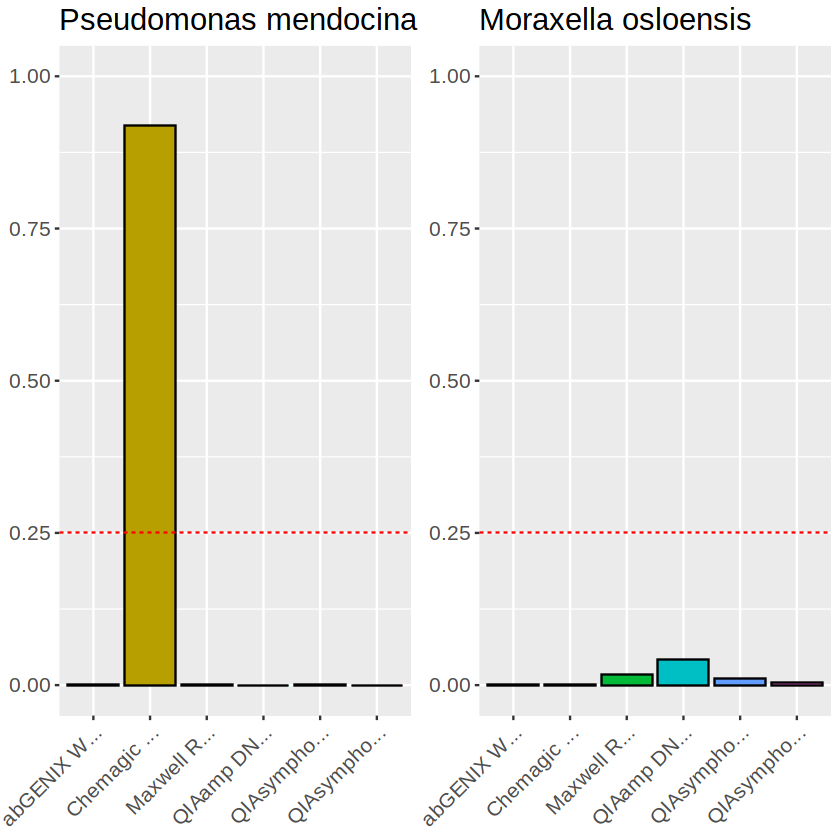

In [16]:
get_prev_plot <- function(taxon) {
    contam_plt <- prev_df %>%
        left_join(meta) %>%
        group_by(extraction_kit) %>%
        summarise(prev = sum(get(taxon)) / n(), n = n()) %>%
        filter(extraction_kit != "Unknown") %>%
        ggplot(aes(x = extraction_kit, y = prev, fill = extraction_kit)) +
            geom_bar(stat = "identity", color = "black") +
            theme(axis.text.x = element_text(angle = 45, hjust = 1),
                  axis.title = element_blank(),
                  text = element_text(size = 15)) +
            scale_x_discrete(label = function(x) stringr::str_trunc(x, 12)) +
            labs(x = "Extraction Kit", y = "Prevalence", title = taxon) +
            geom_hline(yintercept = 0.25, 
                       color = "red",
                       lty = "dashed") +
            ylim(0, 1)
    }
                         
                    
                    
ggarrange(get_prev_plot("Pseudomonas mendocina"), get_prev_plot("Moraxella osloensis"), 
          common.legend = T,
          legend = "none")
                             
ggsave("results/decontamination/contam_versus_nc_prevalence.png", dpi = 600, height = 6.67, width = 7.5)

### Rank species by prevalence and max read count

In [17]:
top_max_count <- prev_max_filt %>% 
    arrange(desc(max_count)) %>% 
    mutate(count_rank = seq(nrow(prev_max_filt)))

top_prev <- prev_max_filt %>% 
    arrange(desc(overall_prevalence)) %>%
    mutate(prev_rank = seq(nrow(prev_max_filt)))

top_max_count %>% 
    full_join(top_prev) %>%
    mutate(ranksum = count_rank + prev_rank) %>%
    arrange(prev_rank)

Joining, by = c("taxa", "max_count", "overall_prevalence", "n_samples", "max_bin")


taxa,max_count,overall_prevalence,n_samples,max_bin,count_rank,prev_rank,ranksum
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>
Cutibacterium acnes,22596,0.047462619,419,>=500,3,1,4
Moraxella osloensis,2402,0.019143634,169,>=500,25,2,27
Human mastadenovirus C,17475,0.018577254,164,>=500,5,3,8
Paraburkholderia sp. 7MH5,182,0.015745356,139,100-500,101,4,105
Paraburkholderia tropica,153,0.014839148,131,100-500,108,5,113
Paraburkholderia acidiphila,188,0.014499320,128,100-500,98,6,104
Paraburkholderia acidisoli,112,0.013253285,117,100-500,120,7,127
Mycolicibacterium aubagnense,1938,0.012233802,108,>=500,28,8,36
Lactobacillus iners,1104,0.012007250,106,>=500,39,9,48


### Get samples with max. read counts

#### Get metadata of top 20 bacterial taxa ranked by max count

In [18]:
top_20 <- top_max_count %>%
    filter(!grepl("Human", taxa)) %>%
    select(taxa, max_count, overall_prevalence, n_samples) %>%
    head(20)

morsels <- foreach (i = seq(nrow(top_20))) %do% {
    row <- top_20[i, ]
    taxon <- row$taxa
    max_count <- row$max_count
    sample_with_max_count <- (species_filt %>% filter(get(taxon) == max_count))$npm_research_id
    
    RA <- species_filt_RA %>% 
        filter(npm_research_id == sample_with_max_count) %>%
        select(all_of(taxon))
    RA <- deframe(RA)
    
    row$max_sample <- sample_with_max_count
    
    return(row)
}

top_20_parsed <- bind_rows(morsels)

top_20_parsed

# fwrite(top_20_parsed, "results/irep_analysis/global_top_20_bacteria_max_count.csv")

taxa,max_count,overall_prevalence,n_samples,max_sample
<chr>,<dbl>,<dbl>,<dbl>,<chr>
Fusobacterium nucleatum,194199,0.0011327594,10,WHB4594
Staphylococcus haemolyticus,117929,0.0105346624,93,0416-0024
Cutibacterium acnes,22596,0.0474626189,419,WHB8433
Staphylococcus cohnii,18768,0.0080425918,71,0416-0024
Neisseria subflava,15385,0.0015858632,14,WHB9179
Corynebacterium segmentosum,14476,0.0010194835,9,WHB6459
Haemophilus parainfluenzae,12183,0.0020389669,18,WHB9179
Fannyhessea vaginae,10395,0.0023787947,21,WHB4035
Staphylococcus epidermidis,9140,0.0086089715,76,WHB6459


[1] "WHB4594"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8818 rows containing non-finite values (stat_bin).”


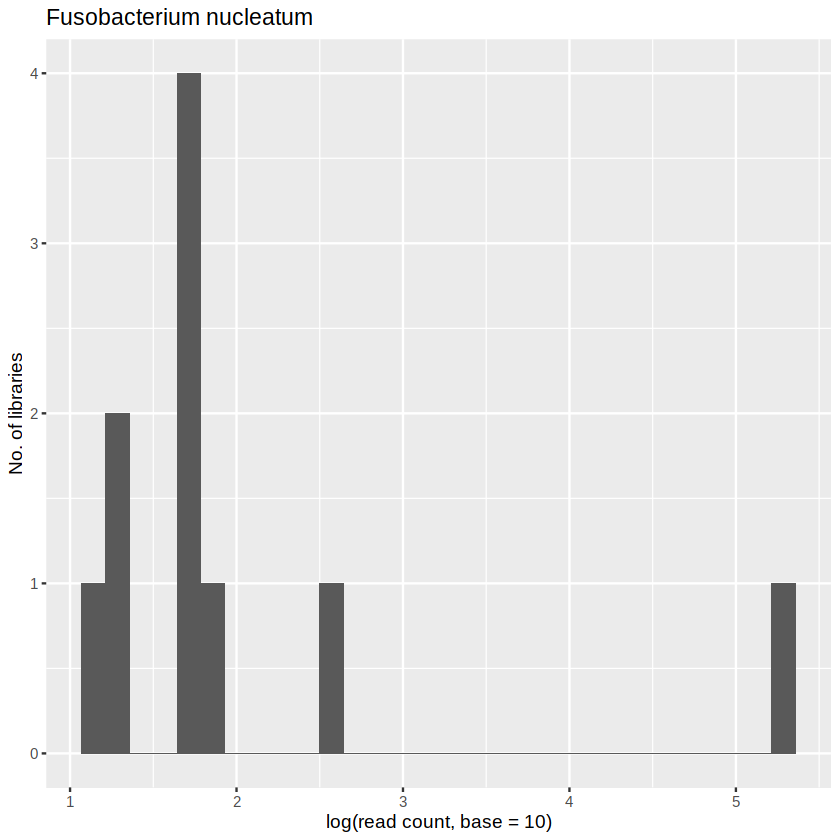

In [19]:
# taxon <- "Paracoccus yeei"
taxon <- "Fusobacterium nucleatum"
# taxon <- "Cutibacterium acnes"
# taxon <- "Bacillus cereus"
# taxon <- "Burkholderia contaminans"
# taxon <- "Microbacterium hominis"
# taxon <- "Microbacterium sp. PM5"
max_count <- prev_max_filt[prev_max_filt$taxa == taxon, ]$max_count
id <- (species_filt %>%
    filter(get(taxon) == max_count))$npm_research_id
print(id)

# species_RA %>% 
#     filter(npm_research_id == id) %>%
#     select(all_of(c(taxon)))

species_filt %>%
    select(all_of(c("npm_research_id", taxon))) %>%
    arrange(desc(get(taxon))) %>%
#     filter(get(taxon) > 100) %>%
    ggplot(aes(x = log(get(taxon), base = 10))) +
    geom_histogram() +
    labs(x = "log(read count, base = 10)", y = "No. of libraries", title = taxon)

### No. of taxa per sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



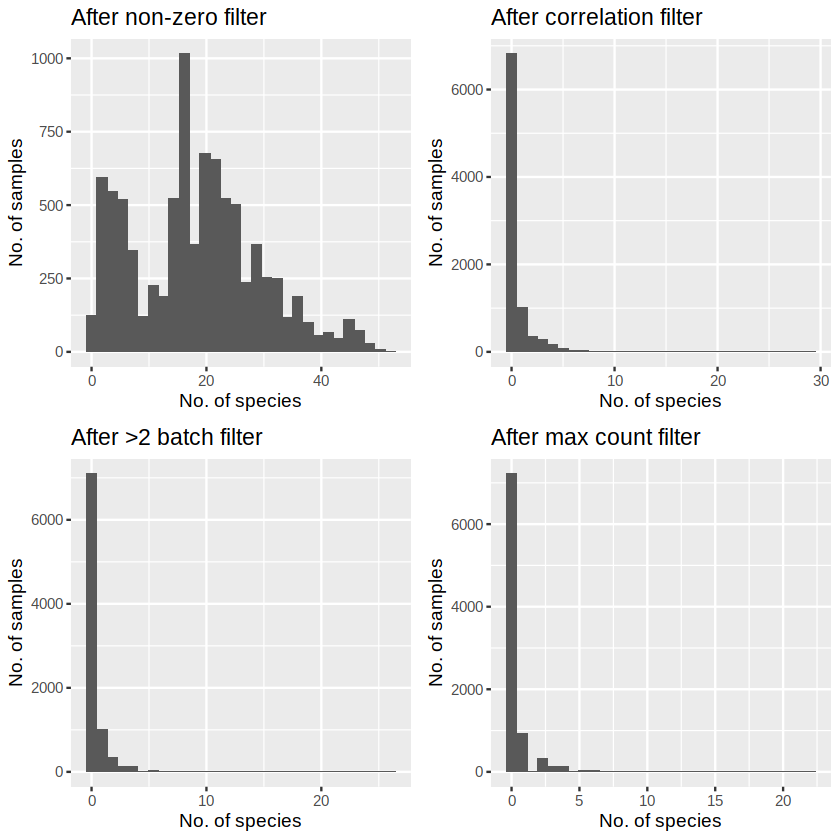

In [20]:
# After PA thresholding
tax_plt <- tibble(n = rowSums(prev_df %>% select(-npm_research_id))) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After non-zero filter")

# After correlation decontamination
species_prev_filt1 <- prev_df %>% select(all_of(corr_nc))
tax_plt1 <- tibble(n = rowSums(species_prev_filt1)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After correlation filter")

# After simple batch filter
species_prev_filt2 <- prev_df %>% select(all_of(batch_nc))
tax_plt2 <- tibble(n = rowSums(species_prev_filt2)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After >2 batch filter")


# After max count filter
species_prev_filt3 <- prev_df %>% select(all_of(prev_max_filt$taxa))
tax_plt3 <- tibble(n = rowSums(species_prev_filt3)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After max count filter")

ggarrange(tax_plt, tax_plt1, tax_plt2, tax_plt3)

n,n_total
<fct>,<int>
0,7216
1,938
2,312
4,132
3,121
5,39
6,24
7,10
8,10


avg
<dbl>
1


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


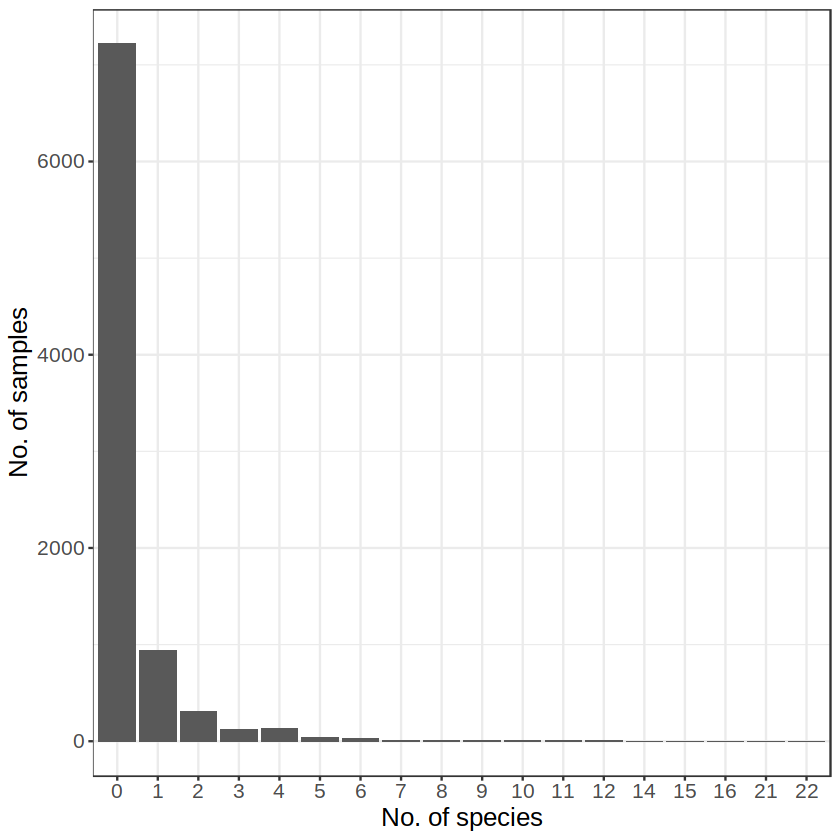

In [21]:
# After max count filter
species_prev_filt3 <- prev_df %>% select(all_of(prev_max_filt$taxa))

tibble(n = rowSums(species_prev_filt3)) %>%
    mutate(n = factor(n)) %>%
    group_by(n) %>%
    summarise(n_total = n()) %>%
    arrange(desc(n_total))

tibble(n = rowSums(species_prev_filt3)) %>%
    filter(n != 0) %>%
    summarise(avg = median(n))

tax_plt3 <- tibble(n = rowSums(species_prev_filt3)) %>%
    mutate(n = factor(n)) %>%
    ggplot(aes(x = n)) +
    geom_histogram(stat = "count") +
    labs(x = "No. of species", y = "No. of samples") +
    theme_bw() +
    scale_x_discrete() +
    theme(text = element_text(size = 15))
tax_plt3
ggsave("results/decontamination/num_microbial_species_per_sample.png", dpi = 600, width = 5, height = 5)

## Is sampling depth a problem?

### Relationship between no. of species per sample and total microbial reads sampled

In [65]:
# microbe_n_spec %>% filter(n_species > 10)
# microbe_n_spec %>% arrange(desc(total_microbial))
# prev_df %>% 
#     filter(npm_research_id == "WHB3479") %>%
#     pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
#     filter(presence)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 124 rows containing non-finite values (stat_bin).”
Saving 6.67 x 6.67 in image

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 124 rows containing non-finite values (stat_bin).”


[1]       0 2193889

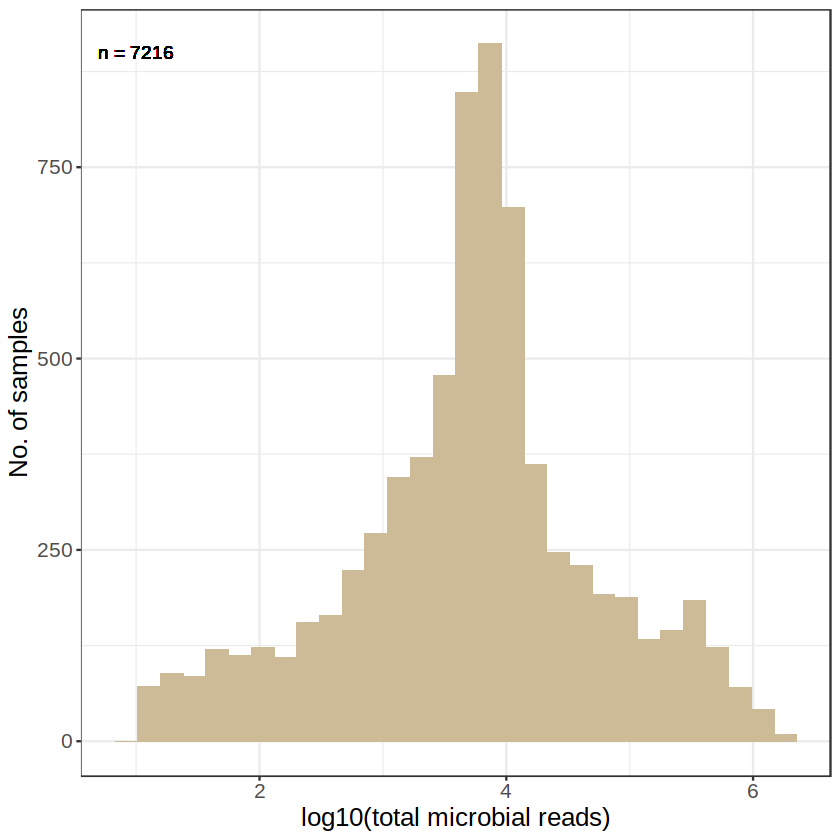

In [66]:
zero_microbes <- microbe_n_spec %>% 
    filter(n_species == 0)
med_read <- zero_microbes %>%
    summarise(median = median(total_microbial))
med_read <- med_read$median

zero_microbes %>% 
    ggplot(aes(x = log(total_microbial, base = 10))) +
    geom_histogram(fill = "wheat3") +
    geom_text(aes(x = 1, y = 900, label = str_glue("n = {nrow(zero_microbes)}"))) +
    theme_bw() +
    theme(text = element_text(size = 15)) +
    labs(x = "log10(total microbial reads)", y = "No. of samples")

ggsave("results/decontamination/zero_microbe_read_distribution.png", dpi = 600)

# Range of reads
range(zero_microbes$total_microbial)

Joining, by = "npm_research_id"
Saving 6.67 x 6.67 in image

Warning message in cor.test.default(microbe_n_spec$n_species, microbe_n_spec$total_microbial, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  microbe_n_spec$n_species and microbe_n_spec$total_microbial
S = 1.4123e+11, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2316966 


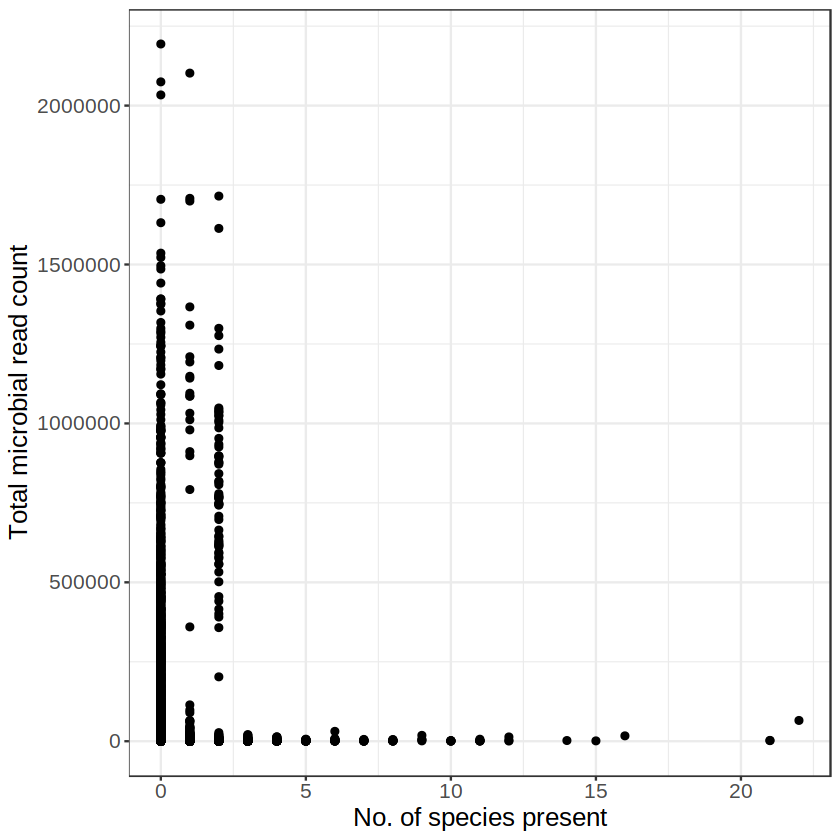

In [22]:
# Total number of microbial reads
total_rowsums <- species_zeroed %>%
    rowSums()

total_rowsums <- tibble(npm_research_id = names(total_rowsums), total_microbial = total_rowsums)

filt_rowsums <- prev_df %>% 
    column_to_rownames("npm_research_id") %>%
    select(all_of(prev_max_filt$taxa)) %>%
    rowSums()

filt_rowsums <- tibble(npm_research_id = names(filt_rowsums), n_species = filt_rowsums)

microbe_n_spec <- total_rowsums %>%
    inner_join(filt_rowsums)

microbe_n_spec %>%
    ggplot(aes(x = n_species, y = total_microbial)) +
    geom_point() +
    labs(x = "No. of species present", y = "Total microbial read count") +
    theme_bw() +
    theme(text = element_text(size = 15))
ggsave("results/decontamination/read_count_n_species_correlation.png", dpi = 600)
cor.test(microbe_n_spec$n_species, microbe_n_spec$total_microbial, method = "spearman")

### Is viral prevalence related to microbial read depth?

Joining, by = "npm_research_id"
`summarise()` has grouped output by 'read_bin'. You can override using the `.groups` argument.
Saving 6.67 x 8 in image



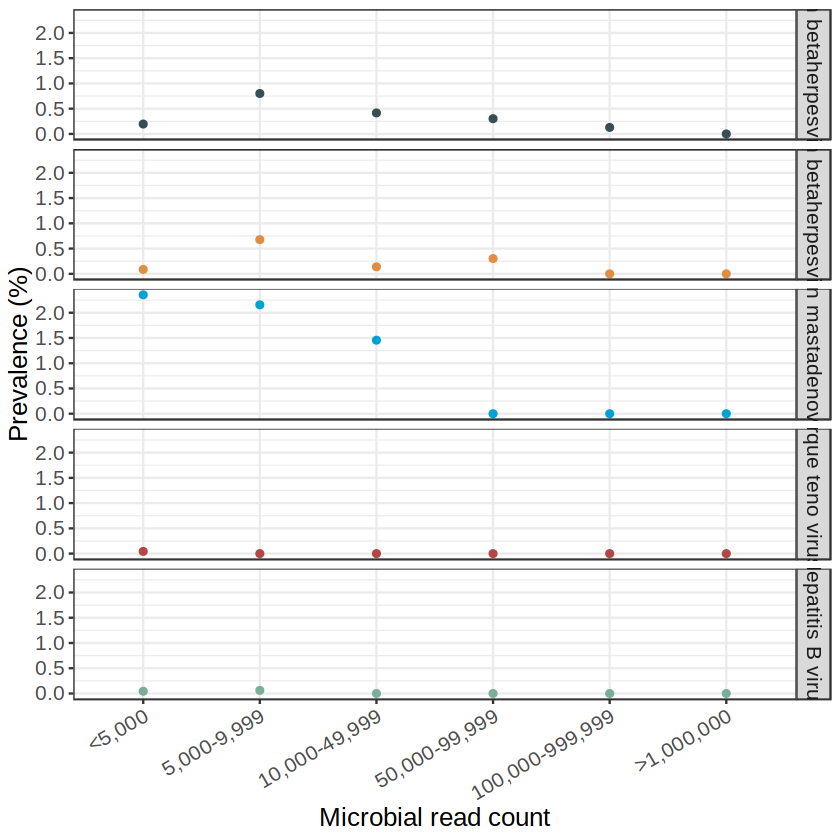

In [90]:
prev_df %>%
    select(npm_research_id, all_of(prev_max_filt$taxa)) %>%
    select(npm_research_id, contains("virus")) %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
    left_join(total_rowsums) %>%
    mutate(read_bin = case_when(total_microbial  < 5000 ~ "<5,000",
                     total_microbial >= 5000 & total_microbial < 10000 ~ "5,000-9,999",
                     total_microbial >= 10000 & total_microbial < 50000 ~ "10,000-49,999",
                     total_microbial >= 50000 & total_microbial < 100000 ~ "50,000-99,999",
                     total_microbial >= 100000 & total_microbial < 1000000 ~ "100,000-999,999",
                     total_microbial >= 1000000 ~ ">1,000,000")) %>%
    mutate(read_bin = factor(read_bin, c("<5,000", "5,000-9,999", 
                                         "10,000-49,999", "50,000-99,999",
                                         "100,000-999,999", ">1,000,000")),
           taxa = factor(taxa, c("Human betaherpesvirus 6B",
                                 "Human betaherpesvirus 6A",
                                 "Human mastadenovirus C",
                                 "Torque teno virus 6",
                                 "Hepatitis B virus"))) %>%
    group_by(read_bin, taxa) %>%
    summarise(n_pos = sum(presence), n = n(), prev = sum(presence) / n()) %>%
    ggplot(aes(x = read_bin, y = prev * 100, color = taxa)) +
    geom_point() +
    facet_grid(rows = vars(taxa)) +
#     geom_text(aes(y = -0.1, label = paste0("n = ", n)), color = "black") +
    labs(x = "Microbial read count", y = "Prevalence (%)", color = "Viral species") +
    theme_bw() +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 30, hjust = 1),
          text = element_text(size = 15)) +
    scale_color_jama()
ggsave("results/decontamination/read_count_viral_prevalence_correlation.png", dpi = 600, height = 8)

Joining, by = "npm_research_id"
`summarise()` has grouped output by 'read_bin'. You can override using the `.groups` argument.
Saving 6.67 x 6.67 in image



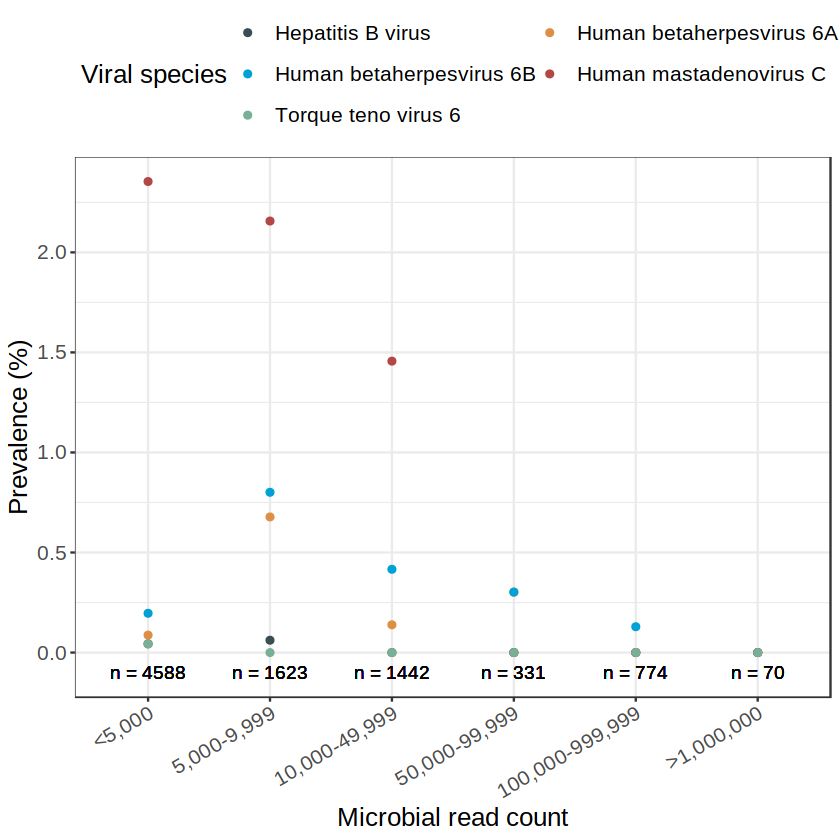

In [91]:
prev_df %>%
    select(npm_research_id, all_of(prev_max_filt$taxa)) %>%
    select(npm_research_id, contains("virus")) %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
    left_join(total_rowsums) %>%
    mutate(read_bin = case_when(total_microbial  < 5000 ~ "<5,000",
                     total_microbial >= 5000 & total_microbial < 10000 ~ "5,000-9,999",
                     total_microbial >= 10000 & total_microbial < 50000 ~ "10,000-49,999",
                     total_microbial >= 50000 & total_microbial < 100000 ~ "50,000-99,999",
                     total_microbial >= 100000 & total_microbial < 1000000 ~ "100,000-999,999",
                     total_microbial >= 1000000 ~ ">1,000,000")) %>%
    mutate(read_bin = factor(read_bin, c("<5,000", "5,000-9,999", 
                                         "10,000-49,999", "50,000-99,999",
                                         "100,000-999,999", ">1,000,000"))) %>%
    group_by(read_bin, taxa) %>%
    summarise(n_pos = sum(presence), n = n(), prev = sum(presence) / n()) %>%
    ggplot(aes(x = read_bin, y = prev * 100, color = taxa)) +
    geom_point() +
    geom_text(aes(y = -0.1, label = paste0("n = ", n)), color = "black") +
    labs(x = "Microbial read count", y = "Prevalence (%)", color = "Viral species") +
    theme_bw() +
    guides(color = guide_legend(nrow = 3, byrow = TRUE)) +
    theme(legend.position = "top", 
          axis.text.x = element_text(angle = 30, hjust = 1),
          text = element_text(size = 15)) +
    scale_color_jama()
ggsave("results/decontamination/read_count_viral_prevalence_correlation.png", dpi = 600)

## No. of microbial reads per sample

### Contaminant to non-contaminant ratio

In [21]:
total_rowsums <- species_zeroed %>%
    rowSums()
nc_rowsums <- species_read_final %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()

tibble(npm_research_id = names(total_rowsums), total_microbial = total_rowsums) %>%
    left_join(tibble(npm_research_id = names(nc_rowsums), nc_microbial = nc_rowsums)) %>%
    mutate(contam_microbial = total_microbial - nc_microbial) %>%
    mutate(ratio = nc_microbial / contam_microbial) %>%
    filter(!is.na(ratio)) %>%
    summarise(median_ratio = median(ratio))

Joining, by = "npm_research_id"


median_ratio
<dbl>
0


In [22]:
total_rowsums <- species_zeroed %>%
    rowSums()

In [23]:
total_rowsums <- species_df %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()
nc_rowsums <- species_read_final %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()
max(total_rowsums)
max(nc_rowsums)

[1] 2434452

[1] 197837

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 7216 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 7216 rows containing non-finite values (stat_bin).”


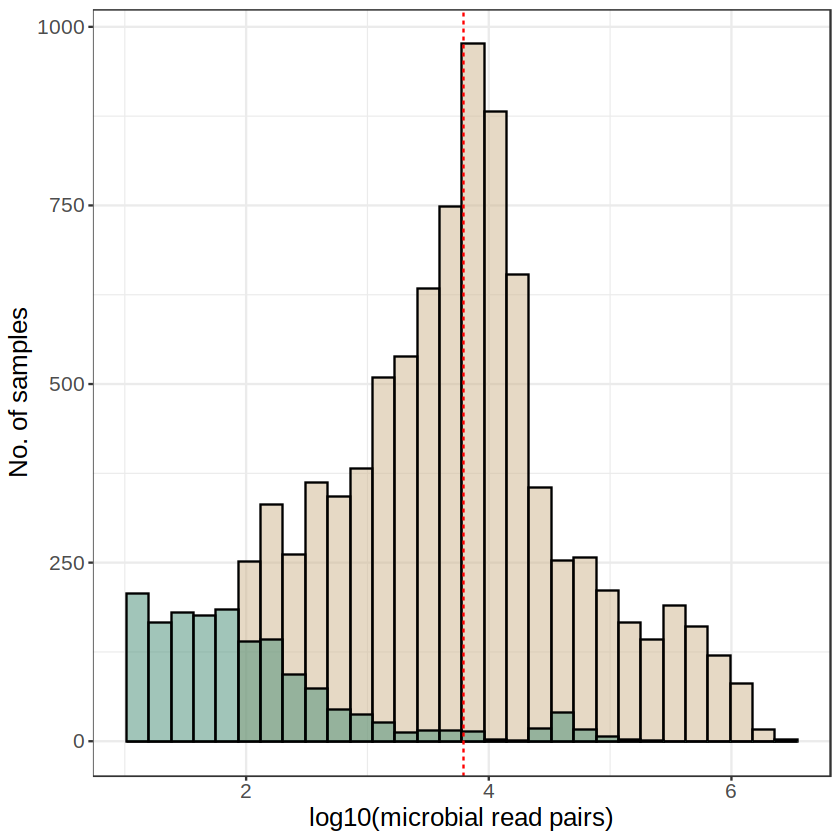

In [24]:
total_rowsums <- species_df %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()
nc_rowsums <- species_read_final %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()

med_nc <- median(log(nc_rowsums, 10))
med_total <- median(log(total_rowsums, 10))

read_plot_df <- tibble(n = total_rowsums, group = "total") %>%
    bind_rows(tibble(n = nc_rowsums, group = "nc")) %>%
    mutate(log_n = log(n, base = 10))

read_plot_df %>%
    ggplot() +
    geom_histogram(data = read_plot_df %>% filter(group == "total"),
                   aes(x = log_n),
                   fill = "navajowhite3",
                   color = "black",
                   alpha = 0.5) +
    geom_histogram(data = read_plot_df %>% filter(group == "nc"),
                   aes(x = log_n),
                   fill = "aquamarine4",
                   color = "black",
                   alpha = 0.5) +
    geom_vline(xintercept = med_total, 
               color = "red",
               lty = "dashed") +
    theme_bw() +
    labs(x = "log10(microbial read pairs)", y = "No. of samples") +
    theme(text = element_text(size = 15))
    
ggsave("results/decontamination/total_microbial_reads.png", dpi = 600, width = 5, height = 5)

In [25]:
median(total_rowsums)

[1] 6138

## Decontaminated taxonomic profiles

### Site level

In [26]:
curated_taxa <- fread("results/decontamination/curated_n124_global_decontamination_stats.parsed.csv")
site_list <- unique(curated_taxa$site)
site_list <- site_list[!(site_list %in% c("", "blood", "eye"))]

taxa_lists <- list()

for(site_name in site_list) {
    taxa_lists[[site_name]] <- (curated_taxa %>% filter(site == site_name))$taxa
}

venn.diagram(
  x = taxa_lists[1:5],
  category.names = names(taxa_lists)[1:5],
  filename = "results/decontamination/site_grouping.venn.png"
)


[1] 1

In [27]:
n_empty <- curated_taxa %>% 
    distinct(taxa, .keep_all = T) %>%
    filter(site == "") %>%
    nrow()
(nrow(curated_taxa %>% distinct(taxa)) - n_empty)
(nrow(curated_taxa %>% distinct(taxa)) - n_empty) /124

[1] 83

[1] 0.6693548

In [28]:
single_site_taxa <- curated_taxa %>%
#     filter(site != "skin") %>%
    filter(site != "") %>%
    group_by(taxa) %>%
    summarise(n_sites = n()) %>%
    filter(n_sites == 1)
single_site_taxa <- single_site_taxa$taxa
length(single_site_taxa)
length(single_site_taxa) / nrow(curated_taxa %>% distinct(taxa))

single_site_non_skin_taxa <- curated_taxa %>%
    filter(site != "skin") %>%
    filter(site != "") %>%
    group_by(taxa) %>%
    summarise(n_sites = n()) %>%
    filter(n_sites == 1)
single_site_non_skin_taxa <- single_site_non_skin_taxa$taxa
length(single_site_non_skin_taxa)
length(single_site_non_skin_taxa) / nrow(curated_taxa %>% distinct(taxa))

[1] 47

[1] 0.3790323

[1] 44

[1] 0.3548387

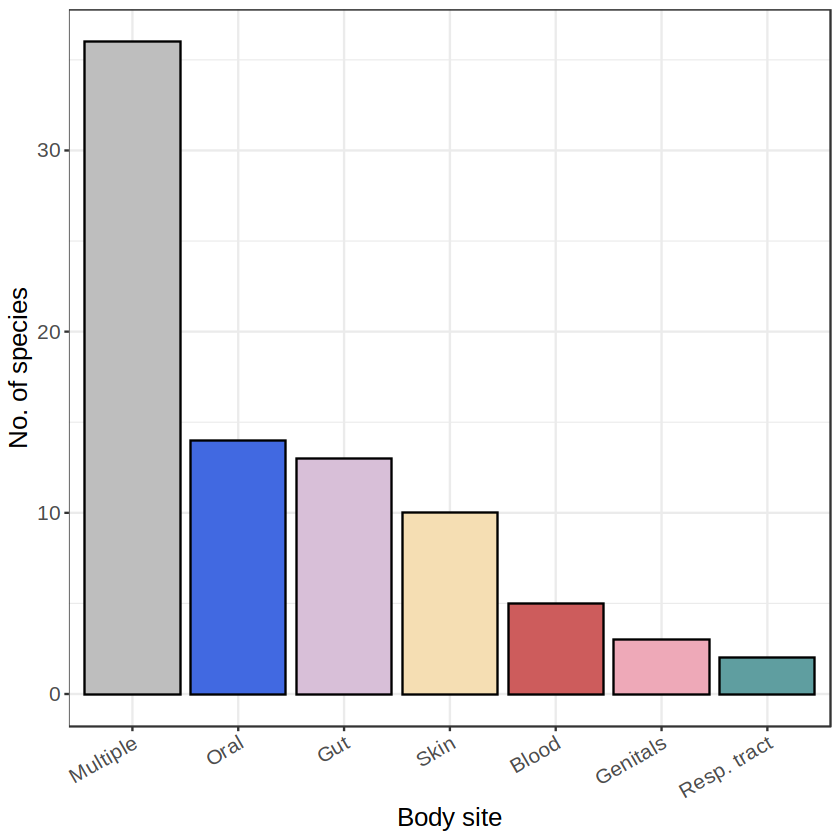

In [29]:
site_morsels <- foreach(taxon = unique(curated_taxa$taxa)) %do% {
    temp <- curated_taxa %>%
        filter(taxa == taxon)
    if (nrow(temp) > 1) {
        temp %>% 
            distinct(taxa, .keep_all = T) %>%
            mutate(site = "Multiple")
    } else {
        temp
    }
}

site_plot_df <- bind_rows(site_morsels) %>%
    mutate(site = Hmisc::capitalize(site)) %>%
    mutate(site = ifelse(site == "Respiratory tract", "Resp. tract", site)) %>%
    filter(site != "") %>%
    group_by(site) %>%
    summarise(n_site = n()) %>%
    arrange(desc(n_site))

site_plot_df %>%
    mutate(site = factor(site, unique(site_plot_df$site))) %>%
    ggplot(aes(x = site, y = n_site, fill = site)) +
    geom_bar(stat = "identity", color = "black") +
    theme_bw() +
    labs(x = "Body site", y = "No. of species") +
    scale_fill_manual(values = c("grey", "royalblue", "thistle",
                                   "wheat", "indianred", "pink2", 
                                   "cadetblue")) +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 30, hjust = 1),
          text = element_text(size = 15))
ggsave("results/decontamination/body_site_counts.png", dpi = 600, width = 5, height = 5)

### Microbiology classification

In [30]:
curated_taxa %>% filter(microbiol_class == "Obligate intracellular")

taxa,genus,max_count,overall_prevalence,n_samples,max_bin,org_group,site,microbiol_class
<chr>,<chr>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
Human mastadenovirus C,Mastadenovirus,17475,0.018577254,164,>=500,Viruses,blood,Obligate intracellular
Human betaherpesvirus 6A,Roseolovirus,8770,0.002038967,18,>=500,Viruses,blood,Obligate intracellular
Human betaherpesvirus 6B,Roseolovirus,8476,0.003398278,30,>=500,Viruses,blood,Obligate intracellular
Hepatitis B virus,Orthohepadnavirus,4979,0.000339828,3,>=500,Viruses,blood,Obligate intracellular
Rickettsia sp. Tillamook 23,Rickettsia,2923,0.000226552,2,>=500,Bacteria,,Obligate intracellular
Rickettsia felis,Rickettsia,1123,0.000226552,2,>=500,Bacteria,,Obligate intracellular
Torque teno virus 6,Alphatorquevirus,496,0.000226552,2,100-500,Viruses,blood,Obligate intracellular
Rickettsia endosymbiont of Bemisia tabaci,Rickettsia,334,0.000226552,2,100-500,Bacteria,,Obligate intracellular


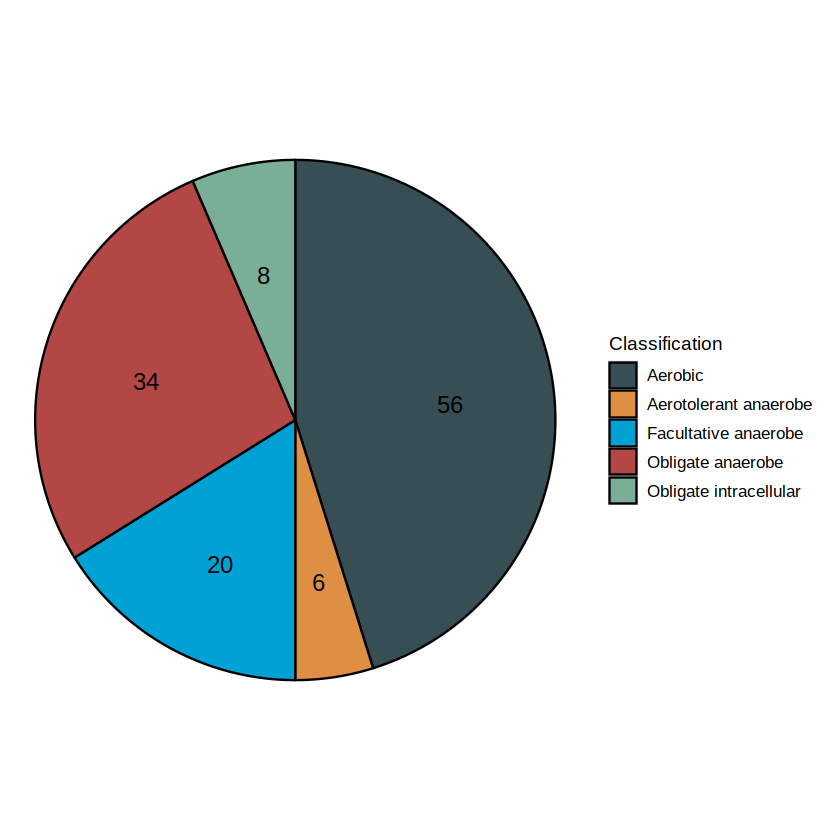

In [31]:
rpie <- 1
rlabel <-  0.6 * rpie

curated_taxa %>%
    distinct(taxa, .keep_all = T) %>%
    group_by(microbiol_class) %>%
    summarise(cnt = n(), total = nrow(df)) %>%
    mutate(end_angle = 2 * pi * cumsum(cnt) / n_distinct(curated_taxa$taxa),      # ending angle for each pie slice
           start_angle = lag(end_angle, default = 0),   # starting angle for each pie slice
           mid_angle = 0.5 * (start_angle + end_angle)) %>%  # middle of each pie slice, for the text label
    ggplot() +
    geom_arc_bar(aes(x0 = 0, y0 = 0, r0 = 0, r = rpie,
                start = start_angle, end = end_angle, fill = microbiol_class)) +
    geom_text(aes(x = rlabel * sin(mid_angle), y = rlabel * cos(mid_angle), label = cnt),
                hjust = 0.5, vjust = 1, size = 5) +
    coord_fixed() +
    scale_x_continuous(limits = c(-1, 1), name = "", breaks = NULL, labels = NULL) +
    scale_y_continuous(limits = c(-1, 1), name = "", breaks = NULL, labels = NULL) +
    scale_fill_jama() +
    theme(legend.text = element_text(size = 10),
          panel.background = element_rect(fill = "white"),
          axis.text = element_blank(),
          axis.title = element_blank(),
          axis.ticks = element_blank()) +
    labs(x = NULL, y = NULL, fill = NULL) +
    labs(fill = "Classification")

ggsave("results/decontamination/microbiology_breakdown.png", dpi = 600, height = 5, width = 5)

### Genus level

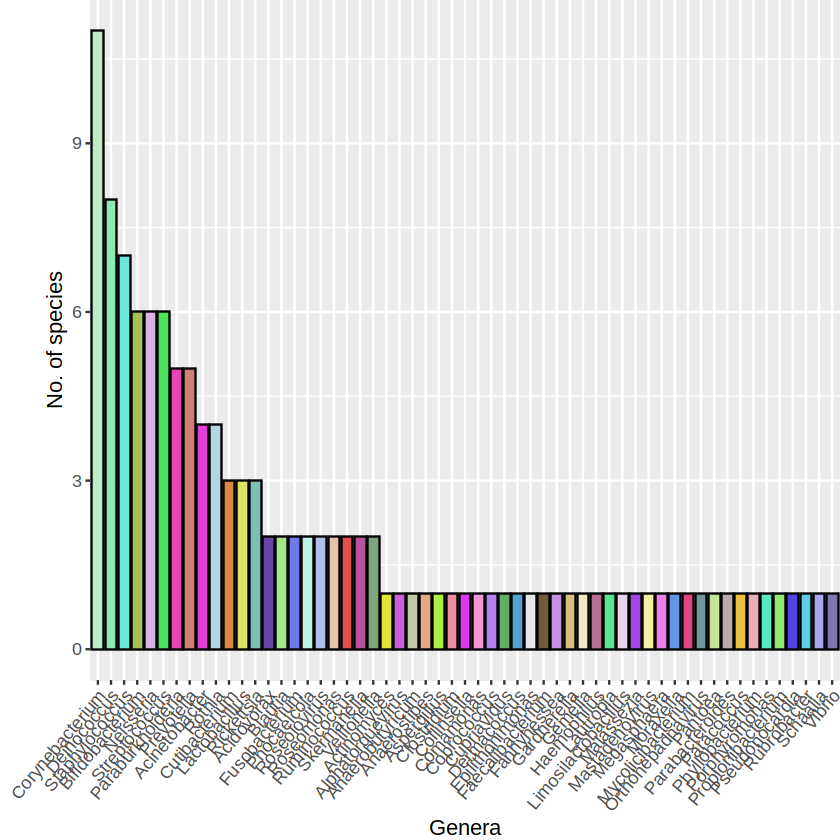

In [32]:
genus_plot_df <- curated_taxa %>%
    distinct(taxa, .keep_all = T) %>%
    group_by(genus) %>%
    summarise(n_species = n()) %>%
    arrange(desc(n_species))

# top10_genera <- genus_plot_df %>% head(30)
# other_genera <- genus_plot_df %>% 
#     filter(!(genus %in% top10_genera$genus)) %>%
#     summarise(genus = "Others", n_species = sum(n_species))

# bind_rows(top10_genera, other_genera) %>%
#     mutate(genus = factor(genus, c(genus_plot_df$genus, "Others"))) %>%
#     ggplot(aes(x = genus, y = n_species)) +
#     geom_bar(stat = "identity") +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

set.seed(66)
pal <- distinctColorPalette(length(unique(genus_plot_df$genus)))

genus_plot_df %>%
    mutate(genus = factor(genus, c(genus_plot_df$genus, "Others"))) %>%
    ggplot(aes(x = genus, y = n_species, fill = genus)) +
    geom_bar(stat = "identity", color = "black") +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 50, hjust = 1),
          plot.margin = unit(c(0, 0, 0, 1), "cm"),
          text = element_text(size = 13)) +
    labs(x = "Genera", y = "No. of species") +
    scale_fill_manual(values = pal)

ggsave("results/decontamination/genus_breakdown.png", dpi = 600, width = 10, height = 3)

### Species level

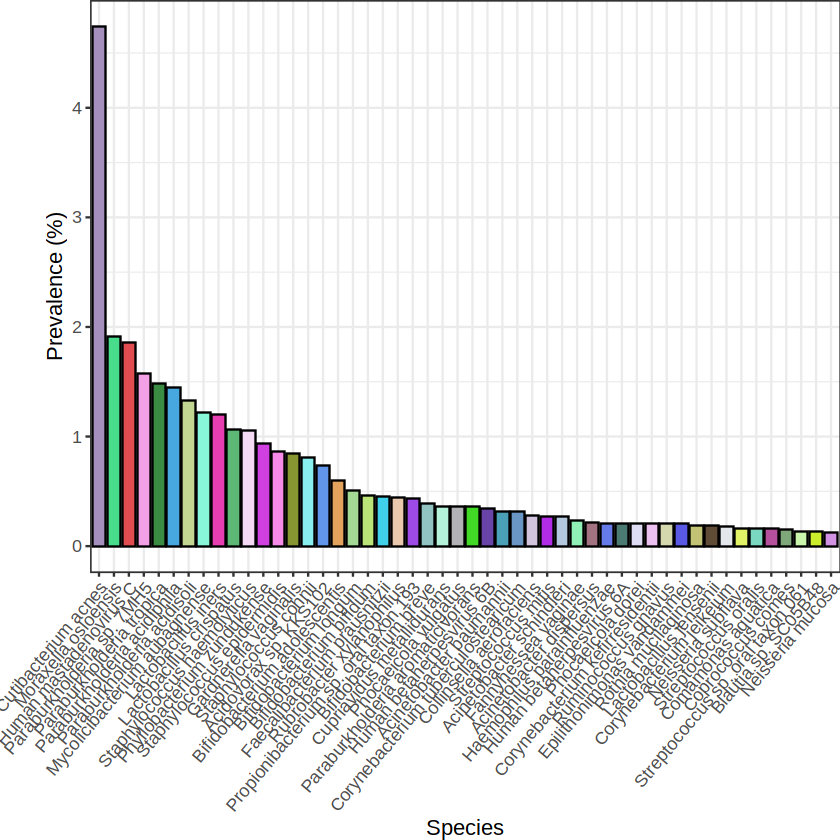

In [33]:
species_plot_df <- curated_taxa %>%
    distinct(taxa, .keep_all = T) %>%
    arrange(desc(overall_prevalence))

set.seed(67)
pal2 <- distinctColorPalette(length(unique(species_plot_df$taxa)))

species_plot_df %>%
    head(50) %>%
    mutate(taxa = factor(taxa, c(species_plot_df$taxa))) %>%
    ggplot(aes(x = taxa, y = overall_prevalence * 100, fill = taxa)) +
    geom_bar(stat = "identity", color = "black") +
    theme_bw() + 
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 50, hjust = 1),
          plot.margin = unit(c(0, 0, 0, 1), "cm"),
          text = element_text(size = 13)) +
    labs(x = "Species", y = "Prevalence (%)") +
    scale_fill_manual(values = pal2)

ggsave("results/decontamination/species_prevalence.png", dpi = 600, width = 10, height = 4)

## Visualising batch effects

### PCoA on BC

In [34]:
X_before_RA <- otu_to_RA(species_zeroed %>% rownames_to_column("npm_research_id")) %>% 
    column_to_rownames("npm_research_id")
X_before_RA <- X_before_RA %>% 
    filter(rowSums(X_before_RA) != 0)

X_after_RA <- otu_to_RA(species_read_final) %>% 
    column_to_rownames("npm_research_id")
X_after_RA <- X_after_RA %>% 
    filter(rowSums(X_after_RA) != 0)


Joining, by = "npm_research_id"
Saving 6.67 x 6.67 in image

Joining, by = "npm_research_id"


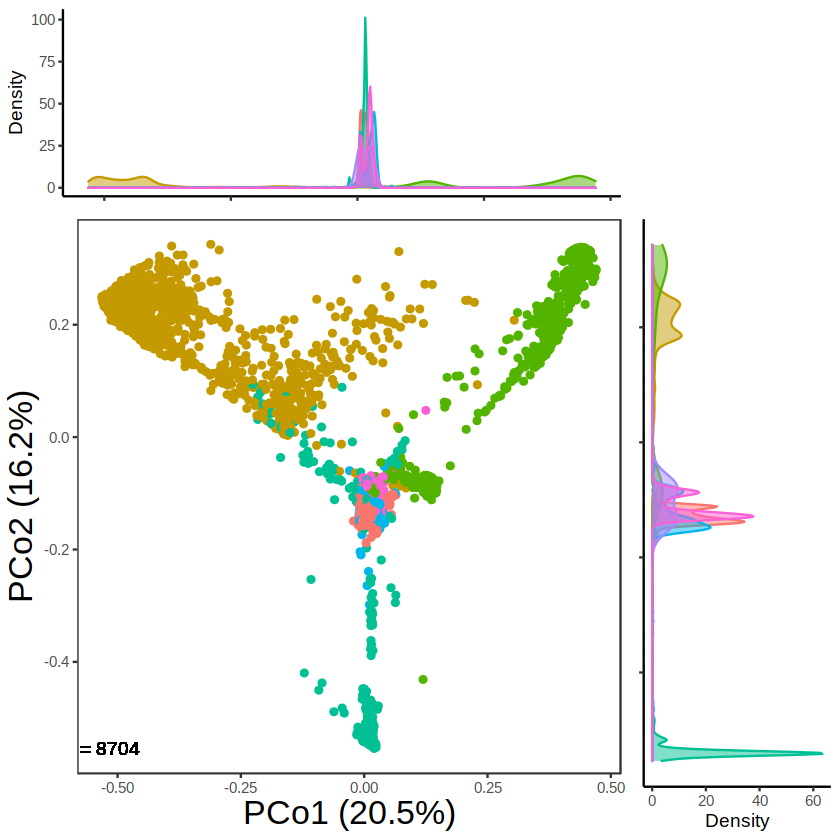

Saving 6.67 x 6.67 in image

Joining, by = "npm_research_id"


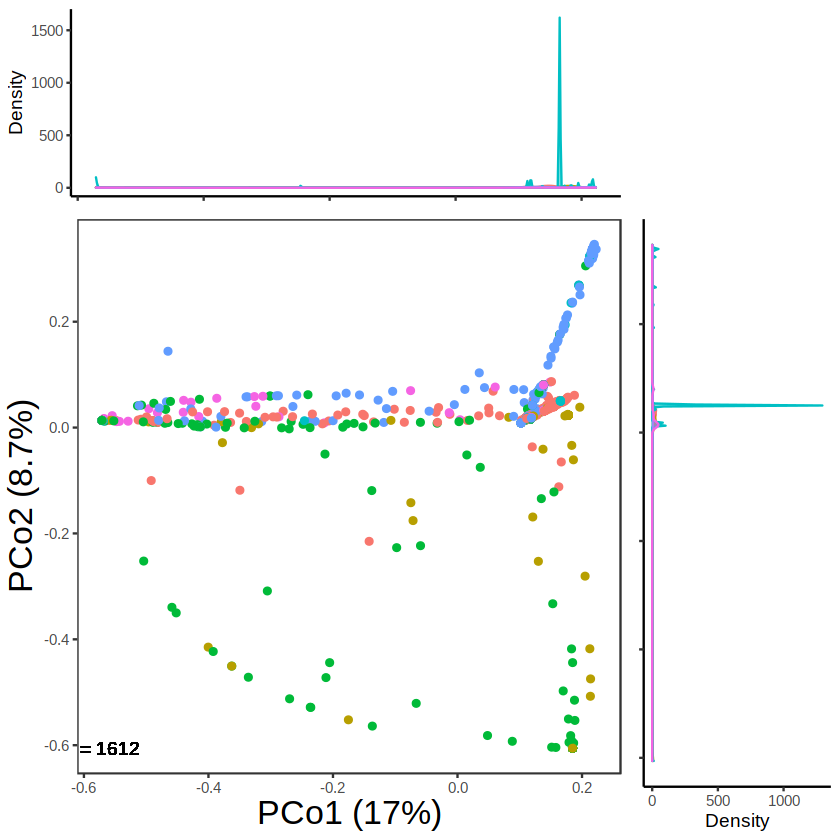

Saving 6.67 x 6.67 in image



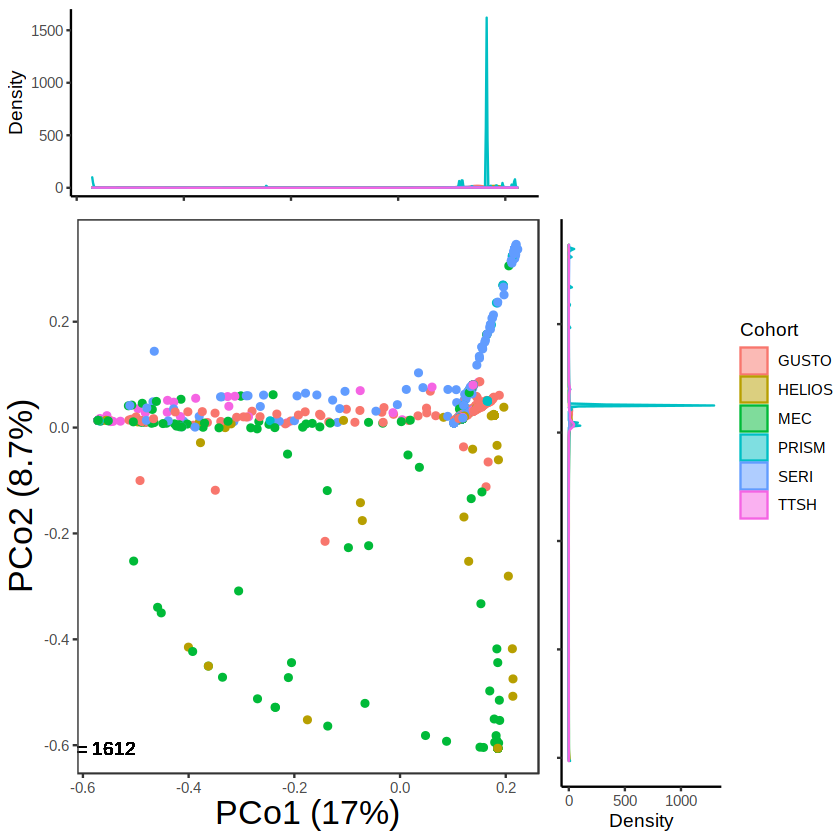

In [35]:
get_pcoa_plot <- function(X, legend) {
    # Get BC distances
    bc_dist <- vegdist(X, method = "bray")
    pcoa <- cmdscale (bc_dist, eig = TRUE)
    
    # Extract proportion of variance
    prop_variance <- pcoa$eig / sum(pcoa$eig)
    PC1_prop <- round(prop_variance[1] * 100, 1)
    PC2_prop <- round(prop_variance[2] * 100, 1)
    
    # Plot
    plot_df <- tibble(npm_research_id = rownames(pcoa$points), 
               PC1 = pcoa$points[, 1], 
               PC2 = pcoa$points[, 2]) %>%
            left_join(meta)
    density_plt1 <- plot_df %>%
        ggplot(aes(x = PC1, fill = site_supplying_sample, color = site_supplying_sample)) + 
            geom_density(alpha = 0.5) + 
            theme_classic() +
            theme(axis.text.x = element_blank(),
                  axis.title.x = element_blank(),
                  legend.position = "none") +
        labs(x = "Density", 
             y = "Density",
             fill = "Cohort", , color = "Cohort")

    density_plt2 <- plot_df %>%
        ggplot(aes(x = PC2, fill = site_supplying_sample, color = site_supplying_sample)) + 
            geom_density(alpha = 0.5) + 
            theme_classic() +
            theme(axis.text.y = element_blank(),
                  axis.title.y = element_blank(),
                  legend.position = "none") +
            coord_flip() +
        labs(x = "Density", 
             y = "Density",
             fill = "Cohort", color = "Cohort")

    empty_plt <- ggplot(plot_df) + 
        geom_blank() +
        theme(panel.background = element_rect("white"))

    scatter_plt <- plot_df %>%
        ggplot(aes(x = PC1, y = PC2, color = site_supplying_sample)) + 
            geom_point() +
            theme(legend.position = "none") +
        labs(x = str_glue("PCo1 ({PC1_prop}%)"), 
             y = str_glue("PCo2 ({PC2_prop}%)"), 
             color = "Cohort") +
        theme_bw() +
        theme(panel.grid = element_blank(),
              axis.title = element_text(size = 20),
              legend.text = element_text(size = 20),
              legend.title = element_text(size = 20),
              legend.position = "none") +
        geom_text(aes(x = min(PC1), 
                      y = min(PC2), 
                      label = str_glue("n = {nrow(plot_df)}")),
                  color = "black")
        
        if (legend) {
            ggarrange(density_plt1, empty_plt, scatter_plt, density_plt2, 
                      nrow = 2, ncol = 2,
                      widths = c(3, 1, 3, 1),
                      heights = c(1, 3, 1, 3),
                      common.legend = T,
                      legend = "right")
        } else {
            ggarrange(density_plt1, empty_plt, scatter_plt, density_plt2, 
                      nrow = 2, ncol = 2,
                      widths = c(3, 1, 3, 1),
                      heights = c(1, 3, 1, 3),
                      common.legend = F)
        }

}

# Get separate plots
get_pcoa_plot(X_before_RA, legend = F)
ggsave("results/decontamination/PCoA/PCoA_Bray_before.png", dpi = 600)
get_pcoa_plot(X_after_RA, legend = F)
ggsave("results/decontamination/PCoA/PCoA_Bray_after.png", dpi = 600)

# Get legend
get_pcoa_plot(X_after_RA, legend = T)
ggsave("results/decontamination/PCoA/PCoA_Bray_after.legend.png", dpi = 600)